In [1]:
from __future__ import print_function

from datetime import datetime
import sys

from azure.storage.file import FileService
import azure.mgmt.batchai.models as models

# The BatchAI/utilities folder contains helper functions used by different notebooks

import utilities as utils

cfg = utils.config.Configuration('configuration.json')
client = utils.config.create_batchai_client(cfg)
## the below message : Keyring cache token has failed: (1783, 'CredWrite', 'The stub received bad data') is not a problem
## source https://stackoverflow.com/questions/50123247/azure-python-sdk-authentication-error

Keyring cache token has failed: (1783, 'CredWrite', 'The stub received bad data')


In [2]:
utils.config.create_resource_group(cfg)
_ = client.workspaces.create(cfg.resource_group, cfg.workspace, cfg.location).result()

Keyring cache token has failed: (1783, 'CredWrite', 'The stub received bad data')


In [ ]:
"""
nodes_count = 1
cluster_name = 'nc6_1'

parameters = models.ClusterCreateParameters(
    #location=cfg.location,
    vm_size='STANDARD_NC6',
    scale_settings=models.ScaleSettings(
        manual=models.ManualScaleSettings(target_node_count=nodes_count)
    ),
    user_account_settings=models.UserAccountSettings(
        admin_user_name=cfg.admin,
        admin_user_password=cfg.admin_password or None,
        admin_user_ssh_public_key=cfg.admin_ssh_key or None,
    )
)
"""

In [3]:

nodes_count = 1
cluster_name = 'nc6_2'
dsvm=False
if dsvm :
    parameters = models.ClusterCreateParameters(
        #location=cfg.location,
        vm_size='STANDARD_NC6',
        scale_settings=models.ScaleSettings(
            manual=models.ManualScaleSettings(target_node_count=nodes_count)
        ), 
        ####### comment out this section when want to use docker image instead of dsvm###########
        virtual_machine_configuration=models.VirtualMachineConfiguration(
            image_reference=models.ImageReference(
                publisher="microsoft-ads",
                offer="linux-data-science-vm-ubuntu",
                sku="linuxdsvmubuntu",
                version="latest")),

        ###################comment out end ####################################
        user_account_settings=models.UserAccountSettings(
            admin_user_name=cfg.admin,
            admin_user_password=cfg.admin_password or None,
            admin_user_ssh_public_key=cfg.admin_ssh_key or None,
        )
    )
else:
    parameters = models.ClusterCreateParameters(
    location=cfg.location,
    vm_size='STANDARD_NC6',
    scale_settings=models.ScaleSettings(
        manual=models.ManualScaleSettings(target_node_count=nodes_count)
    ),
    user_account_settings=models.UserAccountSettings(
        admin_user_name=cfg.admin,
        admin_user_password=cfg.admin_password or None,
        admin_user_ssh_public_key=cfg.admin_ssh_key or None,
    )
    )

location is not a known attribute of class <class 'azure.mgmt.batchai.models.cluster_create_parameters_py3.ClusterCreateParameters'> and will be ignored


In [4]:
_ = client.clusters.create(cfg.resource_group, cfg.workspace, cluster_name, parameters).result()

In [5]:
cluster = client.clusters.get(cfg.resource_group, cfg.workspace, cluster_name)
utils.cluster.print_cluster_status(cluster)

Cluster state: resizing Target: 1; Allocated: 0; Idle: 0; Unusable: 0; Running: 0; Preparing: 0; Leaving: 0


In [ ]:
#### model of train.py adapted from :https://github.com/jocicmarko/ultrasound-nerve-segmentation

In [ ]:
### docker image registry :
#https://github.com/tensorflow/tensorflow/blob/master/tensorflow/tools/docker/README.md

In [6]:
backend = 'tensorflow'
azure_file_share_name = 'datasets'
azure_file_share_subdir='ultrasound'

In [7]:
if backend == 'tensorflow':
    parameters = models.JobCreateParameters(
        #location=cfg.location,
        cluster=models.ResourceId(id=cluster.id),
        node_count=1,
        job_preparation=models.JobPreparation(command_line='python -m pip install keras scikit-image scikit-learn pillow numpy'),
        ####### only comment out the below when you use dsvm instead of docker image in parameters block above
         container_settings=models.ContainerSettings(
             image_source_registry=models.ImageSourceRegistry(image='tensorflow/tensorflow:1.4.0-gpu-py3')),
        ######### commend end #########################
        mount_volumes=models.MountVolumes(
            azure_file_shares=[
            models.AzureFileShareReference(
            account_name=cfg.storage_account_name,
            credentials=models.AzureStorageCredentialsInfo(
            account_key=cfg.storage_account_key),
            azure_file_url='https://{0}.file.core.windows.net/{1}'.format(
            cfg.storage_account_name, 'datasets'), ## datasets is the name of the fileshare
            relative_mount_path='afs')
            ]
         ),
        std_out_err_path_prefix='$AZ_BATCHAI_JOB_MOUNT_ROOT/afs/ultrasound', ## here afs equal to bloodshare level
        tensor_flow_settings=models.TensorFlowSettings(
             python_script_file_path='$AZ_BATCHAI_JOB_MOUNT_ROOT/afs/ultrasound/train.py',
        master_command_line_args='--parent $AZ_BATCHAI_JOB_MOUNT_ROOT/afs/ultrasound/ --load_model N --epoch 20')) 

In [8]:
experiment_name = 'unet_train'
experiment = client.experiments.create(cfg.resource_group, cfg.workspace, experiment_name).result()
job_name = datetime.utcnow().strftime('keras_{}_%m_%d_%Y_%H%M%S'.format(backend))
job = client.jobs.create(cfg.resource_group, cfg.workspace, experiment_name, job_name, parameters).result()
print('Created Job {0} in Experiment {1}'.format(job.name, experiment.name))

Created Job keras_tensorflow_08_10_2018_112829 in Experiment unet_train


In [9]:
if backend == 'tensorflow':
    read_file = 'stdout-wk-0.txt'
elif backend == 'cntk':
    read_file = 'stdout.txt'

utils.job.wait_for_job_completion(client, cfg.resource_group, cfg.workspace, 
                                  experiment_name, job_name, cluster_name, 'stdouterr', read_file)

Cluster state: resizing Target: 1; Allocated: 0; Idle: 0; Unusable: 0; Running: 0; Preparing: 0; Leaving: 0
Job state: queued ExitCode: None
Cluster state: resizing Target: 1; Allocated: 0; Idle: 0; Unusable: 0; Running: 0; Preparing: 0; Leaving: 0
Job state: queued ExitCode: None
Cluster state: resizing Target: 1; Allocated: 0; Idle: 0; Unusable: 0; Running: 0; Preparing: 0; Leaving: 0
Job state: queued ExitCode: None
Cluster state: resizing Target: 1; Allocated: 0; Idle: 0; Unusable: 0; Running: 0; Preparing: 0; Leaving: 0
Job state: queued ExitCode: None
Cluster state: resizing Target: 1; Allocated: 0; Idle: 0; Unusable: 0; Running: 0; Preparing: 0; Leaving: 0
Job state: queued ExitCode: None
Cluster state: resizing Target: 1; Allocated: 0; Idle: 0; Unusable: 0; Running: 0; Preparing: 0; Leaving: 0
Job state: queued ExitCode: None
Cluster state: resizing Target: 1; Allocated: 0; Idle: 0; Unusable: 0; Running: 0; Preparing: 0; Leaving: 0
Job state: queued ExitCode: None
Cluster state

4128/4508 [==========================>...] - ETA: 3s - loss: -0.0250 - dice_coef: 0.0250


4508/4508 [==============================] - 43s 10ms/step - loss: -0.0249 - dice_coef: 0.0249 - val_loss: -0.0195 - val_dice_coef: 0.0195
Epoch 2/20

2592/4508 [================>.............] - ETA: 15s - loss: -0.0271 - dice_coef: 0.0271


4508/4508 [==============================] - 39s 9ms/step - loss: -0.0293 - dice_coef: 0.0293 - val_loss: -0.0286 - val_dice_coef: 0.0286
Epoch 3/20

1120/4508 [======>.......................] - ETA: 27s - loss: -0.0479 - dice_coef: 0.0479


4064/4508 [==========================>...] - ETA: 3s - loss: -0.1751 - dice_coef: 0.1751


4508/4508 [==============================] - 39s 9ms/step - loss: -0.1825 - dice_coef: 0.1825 - val_loss: -0.1655 - val_dice_coef: 0.1655
Epoch 4/20

2560/4508 [================>.............] - ETA: 15s - loss: -0.2556 - dice_coef: 0.2556


4508/4508 [==============================] - 39s 9ms/step - loss: -0.2181 - dice_coef: 0.2181 - val_loss: -6.0282e-04 - val_dice_coef: 6.0282e-04
Epoch 5/20

 896/4508 [====>.........................] - ETA: 29s - loss: -2.7717e-04 - dice_coef: 2.7717e-04


3616/4508 [=======================>......] - ETA: 7s - loss: -2.8156e-04 - dice_coef: 2.8156e-04


4508/4508 [==============================] - 39s 9ms/step - loss: -2.8036e-04 - dice_coef: 2.8036e-04 - val_loss: -6.0393e-04 - val_dice_coef: 6.0393e-04
Epoch 6/20

1952/4508 [===========>..................] - ETA: 20s - loss: -2.7605e-04 - dice_coef: 2.7605e-04


4508/4508 [==============================] - 39s 9ms/step - loss: -2.7936e-04 - dice_coef: 2.7936e-04 - val_loss: -6.0403e-04 - val_dice_coef: 6.0403e-04
Epoch 7/20

 256/4508 [>.............................] - ETA: 34s - loss: -2.6812e-04 - dice_coef: 2.6812e-04


3136/4508 [===================>..........] - ETA: 11s - loss: -2.7741e-04 - dice_coef: 2.7741e-04


4508/4508 [==============================] - 40s 9ms/step - loss: -2.7943e-04 - dice_coef: 2.7943e-04 - val_loss: -6.0415e-04 - val_dice_coef: 6.0415e-04
Epoch 8/20

1504/4508 [=========>....................] - ETA: 24s - loss: -2.7292e-04 - dice_coef: 2.7292e-04


4320/4508 [===========================>..] - ETA: 1s - loss: -2.7806e-04 - dice_coef: 2.7806e-04


4508/4508 [==============================] - 40s 9ms/step - loss: -2.7680e-04 - dice_coef: 2.7680e-04 - val_loss: -6.0427e-04 - val_dice_coef: 6.0427e-04
Epoch 9/20

2528/4508 [===============>..............] - ETA: 16s - loss: -2.7395e-04 - dice_coef: 2.7395e-04


4508/4508 [==============================] - 40s 9ms/step - loss: -2.7920e-04 - dice_coef: 2.7920e-04 - val_loss: -6.0441e-04 - val_dice_coef: 6.0441e-04
Epoch 10/20

 736/4508 [===>..........................] - ETA: 30s - loss: -2.7704e-04 - dice_coef: 2.7704e-04


3520/4508 [======================>.......] - ETA: 8s - loss: -2.7425e-04 - dice_coef: 2.7425e-04


4508/4508 [==============================] - 40s 9ms/step - loss: -2.7579e-04 - dice_coef: 2.7579e-04 - val_loss: -6.0457e-04 - val_dice_coef: 6.0457e-04
Epoch 11/20

1824/4508 [===========>..................] - ETA: 21s - loss: -2.7459e-04 - dice_coef: 2.7459e-04


4508/4508 [==============================] - 40s 9ms/step - loss: -2.7896e-04 - dice_coef: 2.7896e-04 - val_loss: -6.0473e-04 - val_dice_coef: 6.0473e-04
Epoch 12/20



2720/4508 [=================>............] - ETA: 14s - loss: -2.7871e-04 - dice_coef: 2.7871e-04


4508/4508 [==============================] - 40s 9ms/step - loss: -2.7977e-04 - dice_coef: 2.7977e-04 - val_loss: -6.0491e-04 - val_dice_coef: 6.0491e-04
Epoch 13/20

1024/4508 [=====>........................] - ETA: 28s - loss: -2.8320e-04 - dice_coef: 2.8320e-04


3840/4508 [========================>.....] - ETA: 5s - loss: -2.7720e-04 - dice_coef: 2.7720e-04


4508/4508 [==============================] - 40s 9ms/step - loss: -2.7889e-04 - dice_coef: 2.7889e-04 - val_loss: -6.0512e-04 - val_dice_coef: 6.0512e-04
Epoch 14/20

2176/4508 [=============>................] - ETA: 19s - loss: -2.7290e-04 - dice_coef: 2.7290e-04


4508/4508 [==============================] - 40s 9ms/step - loss: -2.7670e-04 - dice_coef: 2.7670e-04 - val_loss: -6.0533e-04 - val_dice_coef: 6.0533e-04
Epoch 15/20

 512/4508 [==>...........................] - ETA: 32s - loss: -2.7315e-04 - dice_coef: 2.7315e-04


3328/4508 [=====================>........] - ETA: 9s - loss: -2.7277e-04 - dice_coef: 2.7277e-04


4508/4508 [==============================] - 40s 9ms/step - loss: -2.7670e-04 - dice_coef: 2.7670e-04 - val_loss: -6.0556e-04 - val_dice_coef: 6.0556e-04
Epoch 16/20

1536/4508 [=========>....................] - ETA: 24s - loss: -2.9464e-04 - dice_coef: 2.9464e-04


4288/4508 [===========================>..] - ETA: 1s - loss: -2.7844e-04 - dice_coef: 2.7844e-04


4508/4508 [==============================] - 40s 9ms/step - loss: -2.7861e-04 - dice_coef: 2.7861e-04 - val_loss: -6.0581e-04 - val_dice_coef: 6.0581e-04
Epoch 17/20

2528/4508 [===============>..............] - ETA: 16s - loss: -2.8197e-04 - dice_coef: 2.8197e-04


4508/4508 [==============================] - 40s 9ms/step - loss: -2.8087e-04 - dice_coef: 2.8087e-04 - val_loss: -6.0608e-04 - val_dice_coef: 6.0608e-04
Epoch 18/20

 800/4508 [====>.........................] - ETA: 30s - loss: -2.7846e-04 - dice_coef: 2.7846e-04


4508/4508 [==============================] - 40s 9ms/step - loss: -2.8080e-04 - dice_coef: 2.8080e-04 - val_loss: -6.0637e-04 - val_dice_coef: 6.0637e-04
Epoch 19/20

1824/4508 [===========>..................] - ETA: 21s - loss: -2.8043e-04 - dice_coef: 2.8043e-04


4508/4508 [==============================] - 40s 9ms/step - loss: -2.7987e-04 - dice_coef: 2.7987e-04 - val_loss: -6.0669e-04 - val_dice_coef: 6.0669e-04
Epoch 20/20

  96/4508 [..............................] - ETA: 35s - loss: -2.5792e-04 - dice_coef: 2.5792e-04


2976/4508 [==================>...........] - ETA: 12s - loss: -2.7693e-04 - dice_coef: 2.7693e-04


4508/4508 [==============================] - 40s 9ms/step - loss: -2.7867e-04 - dice_coef: 2.7867e-04 - val_loss: -6.0701e-04 - val_dice_coef: 6.0701e-04
------------------------------
Loading and preprocessing test data...
------------------------------
------------------------------
Predicting masks on test data...
------------------------------

2000/2000 [==============================] - 5s 3ms/step


------------------------------
Saving predicted masks to files...
------------------------------
Job state: succeeded ExitCode: 0


In [15]:
from azure.storage.file import FileService
file_service = FileService(cfg.storage_account_name, cfg.storage_account_key)
generator = file_service.list_directories_and_files('datasets/ultrasound')
for file_or_dir in generator:
    print(file_or_dir.name, file_or_dir.metadata)

checkpoint_weights.h5 None
data.py None
imgs_id_test.npy None
imgs_mask_test.npy None
imgs_mask_train.npy None
imgs_test.npy None
imgs_train.npy None
model_architecture.json None
model_weights.h5 None
train.py None
60be94cf-bd71-4d05-b7ce-d05fb5968d66 None
test None
train None
__pycache__ None


In [13]:
_ = client.jobs.delete(cfg.resource_group, cfg.workspace, experiment_name, job_name)

In [14]:
_ = client.clusters.delete(cfg.resource_group, cfg.workspace, cluster_name)

In [6]:
from __future__ import print_function

import os
import numpy as np

from skimage.io import imsave, imread
import argparse
from data import load_test_data
image_rows = int(420)
image_cols = int(580)
data_path='./'


In [3]:
#source citation: https://www.kaggle.com/chefele/plot-images-overlaid-with-mask/notebook
###plotting known image vs corresponding segmentation 
# helper functions to help plotting images

IMAGES_TO_SHOW = 10  # configure to taste :)


import numpy as np
import matplotlib.pyplot as plt
import glob, os, os.path
import cv2


def image_with_mask(img, mask):
    # returns a copy of the image with edges of the mask added in red
    img_color = grays_to_RGB(img)
    mask_edges = cv2.Canny(mask, 100, 200) > 0  
    img_color[mask_edges, 0] = 255  # set channel 0 to bright red, green & blue channels to 0
    img_color[mask_edges, 1] = 0
    img_color[mask_edges, 2] = 0
    return img_color

def fimg_to_fmask(img_path):
    # convert an image file path into a corresponding mask file path 
    dirname, basename = os.path.split(img_path)
    maskname = basename.replace(".tif", "_mask.tif")
    return os.path.join(dirname, maskname)

def mask_not_blank(mask):
    return sum(mask.flatten()) > 0

def grays_to_RGB(img):
    # turn 2D grayscale image into grayscale RGB
    return np.dstack((img, img, img)) 

def plot_image(img, title=None, figsize=(15,20)):
    plt.figure(figsize=figsize)
    plt.title(title)
    plt.imshow(img)
    plt.show()


def process_test_sample(data_path):
    imgs_test, imgs_id_test = load_test_data(data_path)
    imgs_test = preprocess(imgs_test)

    imgs_test = imgs_test.astype('float32')
    imgs_show=imgs_test
    mean = np.mean(imgs_test)  # mean for data centering
    std = np.std(imgs_test) 
    imgs_test -= mean
    imgs_test /= std
    return imgs_test, imgs_id_test, imgs_show

def make_prediction(test_img):
    print('-'*30)
    print('Loading and preprocessing test data...')
    print('Predicting masks on test data...')
    print('-'*30)
    test_img=np.expand_dims(test_img, axis=0)
    imgs_mask_test = loaded_model.predict(test_img, verbose=1)
    #np.save(data_path+'imgs_mask_test.npy', imgs_mask_test)
    return imgs_mask_test


#imgs_test=process_test_sample(data_path)


In [4]:
from __future__ import print_function
import os
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.optimizers import Adam

from keras import backend as K
import argparse
from data import load_test_data
K.set_image_data_format('channels_last')  # TF dimension ordering in this code

img_rows = 96
img_cols = 96
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def preprocess(imgs):
    imgs_p = np.ndarray((imgs.shape[0], img_rows, img_cols), dtype=np.uint8)
    for i in range(imgs.shape[0]):
        imgs_p[i] = resize(imgs[i], (img_cols, img_rows), preserve_range=True)

    imgs_p = imgs_p[..., np.newaxis]
    return imgs_p


# load json and create model
from keras.models import model_from_yaml
from keras.models import model_from_json
from keras import backend as K


# serialize model to JSON
import os
json_file = open('best_model_architect.json', 'r')
loaded_model_json = json_file.read()
#json_file.close()

loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("best_model_weights.h5")
print("Loaded model from disk")
from keras.optimizers import Adam
loaded_model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])

Using TensorFlow backend.


Loaded model from disk


In [7]:
imgs_test, imgs_id_test, imgs_show=process_test_sample(data_path)

c:\users\zecharpy\appdata\local\continuum\anaconda3\envs\py36_zbatchai\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
c:\users\zecharpy\appdata\local\continuum\anaconda3\envs\py36_zbatchai\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


idx 11.tif
------------------------------
Loading and preprocessing test data...
Predicting masks on test data...
------------------------------
1/1 [==============================] - 0s 53ms/step


c:\users\zecharpy\appdata\local\continuum\anaconda3\envs\py36_zbatchai\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


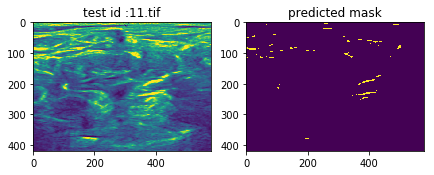

idx 1196.tif
------------------------------
Loading and preprocessing test data...
Predicting masks on test data...
------------------------------
1/1 [==============================] - 0s 68ms/step


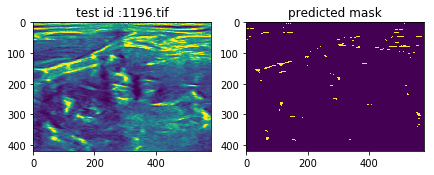

idx 2999.tif
------------------------------
Loading and preprocessing test data...
Predicting masks on test data...
------------------------------
1/1 [==============================] - 0s 85ms/step


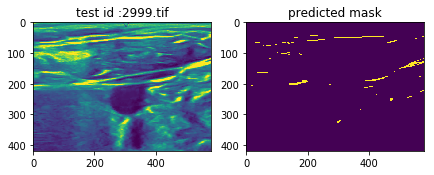

idx 3004.tif
------------------------------
Loading and preprocessing test data...
Predicting masks on test data...
------------------------------
1/1 [==============================] - 0s 55ms/step


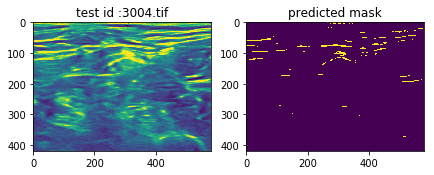

idx 346.tif
------------------------------
Loading and preprocessing test data...
Predicting masks on test data...
------------------------------
1/1 [==============================] - 0s 64ms/step


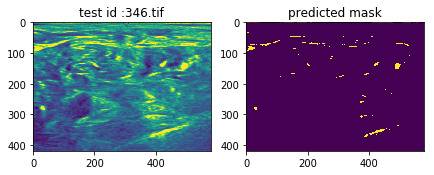

idx 347.tif
------------------------------
Loading and preprocessing test data...
Predicting masks on test data...
------------------------------
1/1 [==============================] - 0s 59ms/step


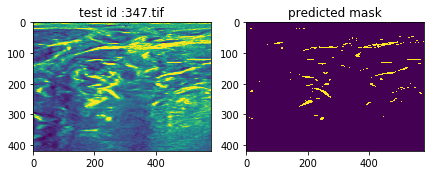

idx 355.tif
------------------------------
Loading and preprocessing test data...
Predicting masks on test data...
------------------------------
1/1 [==============================] - 0s 62ms/step


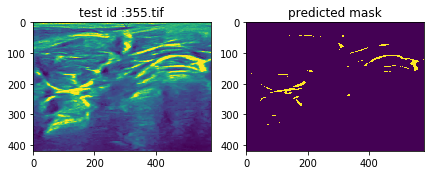

idx 4.tif
------------------------------
Loading and preprocessing test data...
Predicting masks on test data...
------------------------------
1/1 [==============================] - 0s 57ms/step


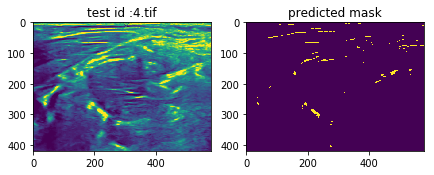

idx 4791.tif
------------------------------
Loading and preprocessing test data...
Predicting masks on test data...
------------------------------
1/1 [==============================] - 0s 45ms/step


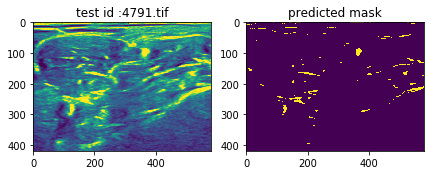

idx 5340.tif
------------------------------
Loading and preprocessing test data...
Predicting masks on test data...
------------------------------
1/1 [==============================] - 0s 65ms/step


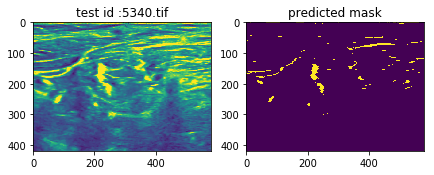

In [11]:
### plot predictions
import random
from skimage.transform import rescale, resize, downscale_local_mean
from matplotlib import pyplot as plt
from IPython.core.pylabtools import figsize
%matplotlib inline
#imgs_id_test=imgs_id_test.tolist()
imgs_id_list=os.listdir('./test/')

IMAGES_TO_SHOW= 5*2

f_ultrasounds = [img for img in imgs_show]

figsize(7, 5)
fig = plt.figure()


images_shown = 0 

for idx ,f_ultrasound in zip(imgs_id_list,f_ultrasounds):
    print("idx",idx)
    ## making prediction
    f_mask=make_prediction(imgs_test[int(idx.split('.')[0])])
    img  = plt.imread("./test/"+idx)
    #print("img shape",img.shape)
    #print("ultra shape and mask shape", f_ultrasound.shape, f_mask.shape)
    if images_shown >= IMAGES_TO_SHOW:
        break
    
    if mask_not_blank(f_mask):
        f_combined = "image id: "+ str(idx) + "predicted segmentation"  
        img_color = grays_to_RGB(f_ultrasound)
        #print("shape", img_color.shape)
        f_ultrasound=f_ultrasound.astype(np.uint8)
        
        f_mask_resize = resize(img, ( 420,580 ),anti_aliasing=True)
        f_mask_resize=f_mask_resize.astype(np.uint8)
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.title("test id :{}".format(str(idx)))
        plt.subplot(1, 2, 2)
        plt.imshow(f_mask_resize)
        plt.title("predicted mask")
        plt.show()
        #print("ultra shape and mask shape", img.shape, f_mask_resize.shape)
        #plot_image(image_with_mask(img, f_mask_resize), title=f_combined)
        #print('plotted:', f_combined)
        images_shown += 1